# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [2]:
#Import the AG news dataset (same as hw01)
#Download them from here 
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

--2023-03-16 08:37:35--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M   167MB/s    in 0.2s    

2023-03-16 08:37:35 (167 MB/s) - ‘train.csv’ saved [29470338/29470338]



,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [3]:
import spacy
dfs = df.sample(200)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

##TODO pre-process text as you did in HW02

dfs['preprocessed'] = dfs['text'].apply(lambda x: nlp(x))

##TODO vectorize the pre-processed text using TfidfVectorizer

vectorizer = TfidfVectorizer()
vec_text = vectorizer.fit_transform(dfs['preprocessed'].astype(str))

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Cosine Similarity and PCA

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
# Cosine_similarity = measure of similarity between two non-zero vectors.
# Used to measure similarity between two documents repr. as vectors of word frequencies or tf-idf weights
# if angle small -> vectors in similar direction -> cosine_sim close to 1 -> high similarity
# if angle close to 90 -> low similarity -> cosine_sim close to 0
# if angle close to 180 -> coseine_sim close to -1 = high dissimilarity
# NLP: find documents that are similar to given query document, or to cluster documents based on similarity

##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

sim = cosine_similarity(vec_text)

first_snipped = sim[0]

# argsort() sorts in ascending order
# gives back index order in order to sort sim
# 1:4 to exclude the first element being the first snipped itself
top_three_ind = first_snipped.argsort()[::-1][1:4]

print('First snipped:', dfs.iloc[0]['preprocessed'])
print()


for i, index in enumerate(top_three_ind):
    print('{}: {}, similarity score = {}'.format(i+1, dfs.iloc[index]['preprocessed'], first_snipped[index]))


First snipped: Table hockey is too limited Of all the great things about being a hockey fan, reading stories about NHL management-labor strife is not one of them. But, rest assured, there is worse. To wit: reporting and writing stories about NHL management-labor strife (you can send notes of sympathy to the e-mail posted at the bottom of this report).

1: McLeish #39;s confidence tempered by Boumsong interest SIMILAR to the actors role, the art of supreme defending is all about timing. The maxim will not be lost on Jean-Alain Boumsong, who is already guaranteed to secure the vote of player of the year from virtually every Rangers supporter., similarity score = 0.14626087061430362
2: Teams United in Desire to Wait for Players in Labor Dispute  TORONTO (Reuters) - National Hockey League teams appeared  united in their determination to solve the league's economic  problems as the NHL's lockout of players became official on  Thursday., similarity score = 0.14192382290669106
3: Comparing Au

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA

pca_vec_text = pca.fit_transform(vec_text.toarray())

##TODO compute again cosine similarity with the reduced version for the first 200 snippets

red_cos_sim = cosine_similarity(pca_vec_text)

##TODO for the first snippet, show again its three most similar snippets

first_snipped = red_cos_sim[0]
top_three_ind = first_snipped.argsort()[::-1][1:4]

print('First snipped:', dfs.iloc[0]['preprocessed'])
print()


for i, index in enumerate(top_three_ind):
    print('{}: {}, similarity score = {}'.format(i+1, dfs.iloc[index]['preprocessed'], first_snipped[index]))


First snipped: Table hockey is too limited Of all the great things about being a hockey fan, reading stories about NHL management-labor strife is not one of them. But, rest assured, there is worse. To wit: reporting and writing stories about NHL management-labor strife (you can send notes of sympathy to the e-mail posted at the bottom of this report).

1: Tendulkar to play in first Test Bangalore, India - India #39;s cricket selectors on Friday picked star batsman Sachin Tendulkar in the squad for the opening match of the Test series against Australia, hoping he will recover from an elbow injury in the next four days., similarity score = 0.9985131307085452
2: United takes title: Eskandarian scores two goals for DC DC United was Major League Soccer #39;s first powerhouse, winning three titles in four years. United surged to the top again yesterday with a 3-2 MLS Cup victory over the Kansas , similarity score = 0.9931294861917389
3: 2005 Tour de France to start on French island, go throu

Compare the cosine similarity before and after PCA reduction. Did the results change? 

Yes, the results do differ. PCA reduces dimensionality of data and only preserves the most imporant relationshipds. When applying cos_sim again on the reduced space, some data may have been lost which leads to different results.

## Clustering

In [6]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters

kmedoids = KMedoids(n_clusters=5, random_state=0)
kmedoids.fit(pca_vec_text)

dfs['kmedoids_cluster'] = kmedoids.labels_

##TODO create the clusters found with k-means clustering nd 5 clusters

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(pca_vec_text)

dfs['kmeans_cluster'] = kmeans.labels_

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.4 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
dfs.head()

,label,title,lead,text,preprocessed,kmedoids_cluster,kmeans_cluster
13599,sport,Table hockey is too limited,Of all the great things about being a hockey f...,Table hockey is too limited Of all the great t...,"(Table, hockey, is, too, limited, Of, all, the...",1,2
61568,business,EU to appeal WTO sugar ruling,The EU is to appeal against a World Trade Orga...,EU to appeal WTO sugar ruling The EU is to ap...,"(EU, to, appeal, WTO, sugar, ruling, , The, E...",0,4
108720,sport,Mets Cut Ties With Hospital,The Mets were one of the first professional sp...,Mets Cut Ties With Hospital The Mets were one ...,"(Mets, Cut, Ties, With, Hospital, The, Mets, w...",0,2
2909,business,Cox directors look at proposed buyout,Cox Communications Inc. is a step closer to go...,Cox directors look at proposed buyout Cox Comm...,"(Cox, directors, look, at, proposed, buyout, C...",3,0
54776,world,British hostage in Iraq dead: Report,"Ken Bigley, a British hostage kidnapped in Bag...",British hostage in Iraq dead: Report Ken Bigle...,"(British, hostage, in, Iraq, dead, :, Report, ...",4,0


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
<ipython-input-8-e85542ca9536>:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)


<Figure size 720x576 with 0 Axes>

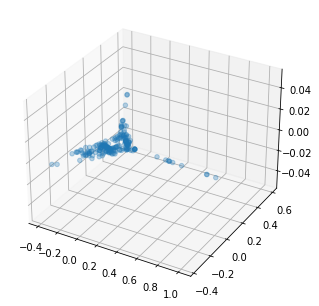

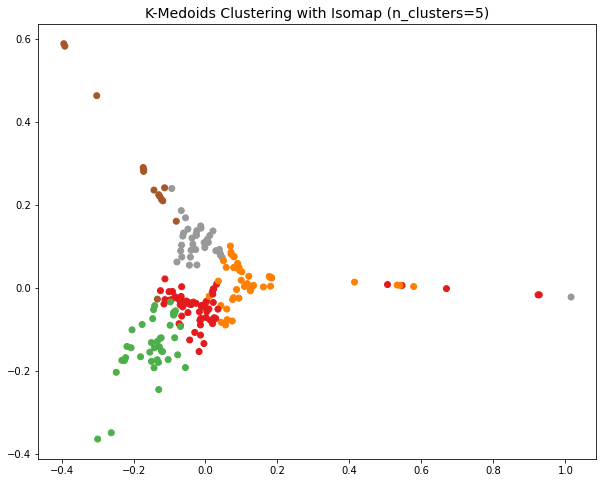

In [8]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)

from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

iso = Isomap(n_components=2)
iso_vec_text = iso.fit_transform(pca_vec_text)

plt.figure(figsize=(10,8))
Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)

# Scatter plot of k-medoids clusters using Isomap
plt.figure(figsize=(10,8))
plt.scatter(iso_vec_text[:,0],iso_vec_text[:,1], c=dfs['kmedoids_cluster'], cmap='Set1')
plt.title('K-Medoids Clustering with Isomap (n_clusters=5)', fontsize=14)
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
<ipython-input-9-fab2099f4395>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)


<Figure size 720x576 with 0 Axes>

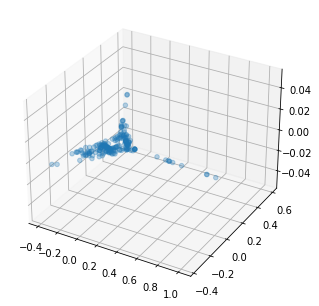

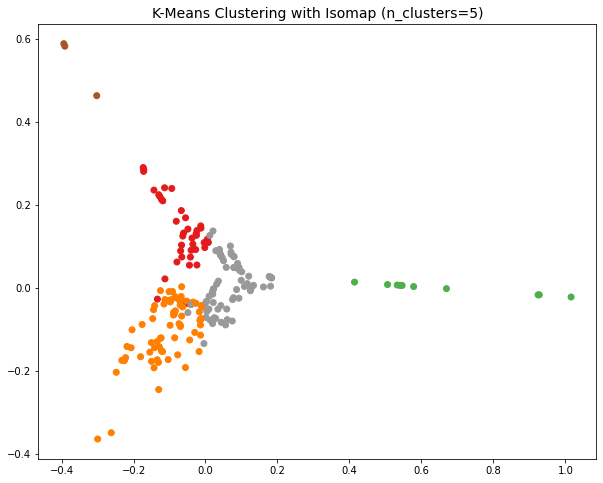

In [9]:
##TODO similarly, visualize the k-means results

iso = Isomap(n_components=2)
iso_vec_text = iso.fit_transform(pca_vec_text)

plt.figure(figsize=(10,8))
Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)

# Scatter plot of k-medoids clusters using Isomap
plt.figure(figsize=(10,8))
plt.scatter(iso_vec_text[:,0],iso_vec_text[:,1], c=dfs['kmeans_cluster'], cmap='Set1')
plt.title('K-Means Clustering with Isomap (n_clusters=5)', fontsize=14)
plt.show()

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [18]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from random import shuffle

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

doc_clean = []

for doc in tqdm(dfs['text']):
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))

shuffle(doc_clean)

dictionary = Dictionary(doc_clean)
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)

##TODO create the doc_term_matrix

doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

100%|██████████| 200/200 [00:02<00:00, 79.89it/s]


In [19]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

--2023-03-16 08:43:44--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-03-16 08:43:44--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  42.3MB/s    in 0.4s    

2023-03-16 08:43:45 (42.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [24]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
mallet_path = '/content/mallet-2.0.8/bin/mallet'

ldamallet_5 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=5, id2word=dictionary)
ldamallet_10 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=10, id2word=dictionary)
ldamallet_15 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=15, id2word=dictionary)

models = [ldamallet_5, ldamallet_10, ldamallet_15]

##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.

scores = []
all_topics = []

for model in models:
    coherence = CoherenceModel(model = model, texts = doc_clean, dictionary=dictionary, coherence = 'c_v')
    topics = model.show_topics()
    print(topics)
    scores.append(coherence.get_coherence())


/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is

In [ ]:
models = [ldamallet_5, ldamallet_10, ldamallet_15]

##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.

scores = []
all_topics = []

for model in models:
    coherence = CoherenceModel(model = model, texts = doc_clean, dictionary=dictionary, coherence = 'c_v')
    topics = model.show_topics(num_topics=1, num_words=10, formatted=False)[0][1]
    topics = [word for word, coherence in topics if coherence > 0.0]
    all_topics.append(topics)
    scores.append(coherence.get_coherence())

print(scores.index(max(scores)))
print(all_topics)
print(all_topics[scores.index(max(scores))])

In [35]:
print(scores)

[0.3665226574009844, 0.3693639266012975, 0.36869999213106497]


In [22]:
# !pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers
##TODO using LDAvis visualize the topics using the optimal number of topics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 23.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.
